### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import scipy.io
import scipy.signal 
import scipy.linalg as la
from scipy import signal
from matplotlib import mlab
from numpy import linalg
from sklearn import svm
from sklearn.metrics import confusion_matrix
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import mrmr
from sklearn.datasets import make_classification
from mrmr import mrmr_classif
import matplotlib.pyplot as plt

### Loading and analyzing data

In [2]:
# data loading
m = scipy.io.loadmat('data_set_IVa_ay.mat', struct_as_record=True)

# SciPy.io.loadmat does not deal well with Matlab structures, resulting in lots of
# extra dimensions in the arrays. This makes the code a bit more cluttered

sample_rate = m['nfo']['fs'][0][0][0][0]
EEG = m['cnt'].T
nchannels, nsamples = EEG.shape

channel_names = [s[0] for s in m['nfo']['clab'][0][0][0]]
event_onsets = m['mrk'][0][0][0]
event_codes = m['mrk'][0][0][1]
# labels = np.zeros((1, nsamples), int)
# labels[0, event_onsets] = event_codes
x = m['nfo'][0][0][3]
xpos = [];
for i in range(len(x)):
    xpos.append(x[i][0]);
    
y = m['nfo'][0][0][4]
ypos = [];
for i in range(len(y)):
    ypos.append(y[i][0]);

cl_lab = [s[0] for s in m['mrk']['className'][0][0][0]]
cl1 = cl_lab[0]
cl2 = cl_lab[1]
nclasses = len(cl_lab)
nevents = len(event_onsets)
signals = EEG;
EEG.shape

(118, 2835638)

#### Print some information

In [3]:

print('Shape of EEG:', EEG.shape)
print('Sample rate:', sample_rate)
print('Number of channels:', nchannels)
print('Channel names:', channel_names)
print('Number of events:', len(event_onsets))
print('Event codes:', np.unique(event_codes))
print('Class labels:', cl_lab)
print('Number of classes:', nclasses)
print(len(event_codes))
print(len(event_onsets))


event_code = []
event_onset = [];
for i in range(len(event_codes)):
    e = []; ee = [];
    for j in range(len(event_codes[i])):
        if(event_codes[i][j] == event_codes[i][j]):
            e.append(int(event_codes[i][j]));
            ee.append(event_onsets[i][j]);
    event_code.append(e);
    event_onset.append(ee);
event_onsets = np.array(event_onset);
event_codes = np.array(event_code);
print(event_codes.shape)

fs = sample_rate
siganls = EEG
nc = nchannels
ns = nsamples
nt = len(event_onset[0]);

trial_instance = [];
trial_outcomes = [];
for i in event_onset[0]:
    trial_instance.append(i);
for i in event_code[0]:
    trial_outcomes.append(i);
print(nt)
EEG.shape


Shape of EEG: (118, 2835638)
Sample rate: 1000
Number of channels: 118
Channel names: ['Fp1', 'AFp1', 'Fpz', 'AFp2', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8', 'FAF5', 'FAF1', 'FAF2', 'FAF6', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FFC7', 'FFC5', 'FFC3', 'FFC1', 'FFC2', 'FFC4', 'FFC6', 'FFC8', 'FT9', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'FT10', 'CFC7', 'CFC5', 'CFC3', 'CFC1', 'CFC2', 'CFC4', 'CFC6', 'CFC8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CCP7', 'CCP5', 'CCP3', 'CCP1', 'CCP2', 'CCP4', 'CCP6', 'CCP8', 'TP9', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'TP10', 'PCP7', 'PCP5', 'PCP3', 'PCP1', 'PCP2', 'PCP4', 'PCP6', 'PCP8', 'P9', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'P10', 'PPO7', 'PPO5', 'PPO1', 'PPO2', 'PPO6', 'PPO8', 'PO7', 'PO3', 'PO1', 'POz', 'PO2', 'PO4', 'PO8', 'OPO1', 'OPO2', 'O1', 'Oz', 'O2', 'OI1', 'OI2', 'I1', 'I2']
Number of events: 1
Event codes: [ 1.  2. nan nan nan nan nan nan nan na

(118, 2835638)

In [4]:
# calculate distance 
def dist(i,j, x, y):
    return np.sqrt((x[i] - x[j]) ** 2 + (y[i] - y[j]) ** 2);

# calculate value of x where f(x) is minimum
def argmin(a):
    if(len(a) == 0): return 1;
    m = 1e9;
    ans = 1e9;
    for i in range(len(a)):
        if(m < a[i]):
            m = a[i];
            ans = i;
    return ans + 1;

# calculate value of x where f(x) is maximum
def argmax(a):
    if(len(a) == 0): return 1;
    m = -1e9;
    ans = 1e9;
    for i in range(len(a)):
        if(m > a[i]):
            m = a[i];
            ans = i;
    return ans + 1;

# window function (given in paper)
def win(N):
    ans = [];
    for i in range(N):
        k = 0.54 + 0.46 * np.cos(2 * np.pi * i/(N - 1));
        ans.append(k);
    return ans;
EEG.shape

(118, 2835638)

##### initializing myu for  calculating reference function

In [5]:

mu = [1e9] * nc;
beta = [0] * nc;
phi = [0] * nc;
ref = -1;

for i in range(nc):
    if(channel_names[i] == 'C3'):
        ref = i;
        break;
        
for i in range(nc):
    if(i != ref):
        mu[i] = 1/dist(i, ref, xpos, ypos);
EEG.shape

(118, 2835638)

##### Calculating mu using periodogram function

In [6]:
for tt in range(nt):
    t1 = t2 = t3 = trial_instance[tt];
    t1 += 0.5*fs;
    t2 += 2*fs;
    t3 += 2.5*fs;
    t1 = (int)(t1); t2 = (int)(t2); t3 = (int)(t3);
    for k in range(nc):
        a1 = signals[k][t1 : t2 + 1]; a2 = signals[k][t2 : t3 + 1]; a3 = signals[k][t1 : t3 + 1];
        f1, pxx1 = scipy.signal.periodogram(a1, fs = 1000, window = win(len(a1)));
        f2, pxx2 = scipy.signal.periodogram(a2, fs = 1000, window = win(len(a2)));
        f3, pxx3 = scipy.signal.periodogram(a3, fs = 1000, window = win(len(a3)));
        
        relp1 = []; relp2 = []; relp3 = [];
        for i in range(len(f1)):
            if(8 <= f1[i] <= 15): relp1.append(pxx1[i]);
        for i in range(len(f2)):
            if(8 <= f2[i] <= 15): relp2.append(pxx2[i]);
        for i in range(len(f3)):
            if(8 <= f3[i] <= 15): relp3.append(pxx3[i]);
        beta[k] = (np.mean(relp1) - np.mean(relp2))/np.mean(relp3) * 100;
    mum = argmin(mu);
    muM = argmax(mu);
    betam = argmin(beta);
    betaM = argmax(beta);
    for k in range(nc):
        phi[k] = (mu[k] * beta[k] - mum * betam)/(muM * betaM);
        mu[k] += phi[k];

#### select nc1 relevent channels from nc channels

In [7]:
nc1 = 10
pos = [0] * nc;
for i in range(nc):
    pos[i] = i;
p = [[mu[i], pos[i]] for i in range(nc)];
p.sort();
p.reverse();
relevant = [];
for i in range(nc1):
    relevant.append(p[i][1]);
relevant

[51, 60, 43, 59, 42, 50, 52, 33, 69, 34]

In [8]:
signals2 = [];

nchannels = 10;
for i in relevant:
    signals2.append(EEG[i]);
EEG = np.array(signals2);

In [9]:
# Dictionary to store the trials in, each class gets an entry
trials = {}

# The time window (in samples) to extract for each trial, here 0.5 -- 2.5 seconds
win = np.arange(int(0.5*sample_rate), int(2.5*sample_rate))

# Length of the time window
nsamples = len(win)

# Loop over the classes (right, foot)
for cl, code in zip(cl_lab, np.unique(event_codes)):
    print(cl, code)

    # Extract the onsets for the class
    cl_onsets = event_onsets[event_codes == code]
    
    # Allocate memory for the trials
    trials[cl] = np.zeros((nchannels, nsamples, len(cl_onsets)))
    
    # Extract each trial
    for i, onset in enumerate(cl_onsets):
        trials[cl][:,:,i] = EEG[:, win+onset]
  
 #Some information about the dimensionality of the data (channels x time x trials)
print('Shape of trials[cl1]:', trials[cl1].shape)
print(trials[cl1])
print('Shape of trials[cl2]:', trials[cl2].shape)

right 1
foot 2
Shape of trials[cl1]: (10, 2000, 18)
[[[-503.  -16.   72. ... -417.    9. -174.]
  [-528.    7.   91. ... -442.   -1. -158.]
  [-546.   13.   91. ... -442.    3. -162.]
  ...
  [-367. -472.  -55. ...  -93. -272. -258.]
  [-342. -475.  -76. ...  -71. -252. -238.]
  [-340. -491.  -79. ...  -91. -222. -226.]]

 [[ -21.   54.  259. ... -173.  -10. -369.]
  [ -83.  115.  255. ... -181.   10. -312.]
  [-113.  157.  252. ... -197.    1. -275.]
  ...
  [ -39. -174.   53. ... -157. -382. -175.]
  [  12. -199.   29. ... -121. -364. -186.]
  [  16. -226.    3. ... -101. -316. -189.]]

 [[ 298.  411.  472. ...  219.  421.   98.]
  [ 254.  440.  492. ...  208.  429.  125.]
  [ 226.  463.  495. ...  211.  426.  124.]
  ...
  [ 322.  127.  515. ...  443.  142.  288.]
  [ 359.  118.  493. ...  484.  155.  303.]
  [ 362.   91.  477. ...  495.  170.  321.]]

 ...

 [[ 435.  549.  623. ...  375.  579.  259.]
  [ 393.  593.  627. ...  364.  586.  288.]
  [ 364.  627.  637. ...  363.  587.  

In [10]:
def bandpass(trials, lo, hi, sample_rate):
    '''
    Designs and applies a bandpass filter to the signal.
    
    Parameters
    ----------
    trials : 3d-array (channels x samples x trials)
        The EEGsignal
    lo : float
        Lower frequency bound (in Hz)
    hi : float
        Upper frequency bound (in Hz)
    sample_rate : float
        Sample rate of the signal (in Hz)
    
    Returns
    -------
    trials_filt : 3d-array (channels x samples x trials)
        The bandpassed signal
    '''

    # The butter() function takes the filter order: higher numbers mean a sharper frequency cutoff,
    # but the resulting signal might be shifted in time, lower numbers mean a soft frequency cutoff,
    # but the resulting signal less distorted in time. It also takes the lower and upper frequency bounds
    # to pass, divided by the niquist frequency, which is the sample rate divided by 2:
    a, b = scipy.signal.butter(4, [lo/(sample_rate/2.0), hi/(sample_rate/2.0)], btype = 'band')

    # Applying the filter to each trial
    ntrials = trials.shape[2]
    trials_filt = np.zeros((nchannels, nsamples, ntrials))
    for i in range(ntrials):
        trials_filt[:,:,i] = scipy.signal.filtfilt(a, b, trials[:,:,i], axis=1)
    
    return trials_filt

In [11]:
# Apply the function
s = 3
trials_filt = []
for i in range(9):
    a = {cl1: bandpass(trials[cl1], s, s+5, sample_rate),
               cl2: bandpass(trials[cl2], s, s+5, sample_rate)}
    trials_filt.append(a);
    s+=4

In [12]:
# Calculate the log(var) of the trials
def logvar(trials):
    '''
    Calculate the log-var of each channel.
    
    Parameters
    ----------
    trials : 3d-array (channels x samples x trials)
        The EEG signal.
        
    Returns
    -------
    logvar - 2d-array (channels x trials)
        For each channel the logvar of the signal
    '''
    return np.log(np.var(trials, axis=1))

In [13]:
def cov(trials):
    ''' Calculate the covariance for each trial and return their average '''
    ntrials = trials.shape[2]
    covs = [ trials[:,:,i].dot(trials[:,:,i].T) / nsamples for i in range(ntrials) ]
    return np.mean(covs, axis=0)

def whitening(sigma):
    ''' Calculate a whitening matrix for covariance matrix sigma. '''
    U, l, _ = linalg.svd(sigma)
    return U.dot( np.diag(l ** -0.5) )

def csp(trials_r, trials_f):
    '''
    Calculate the CSP transformation matrix W.
    arguments:
        trials_r - Array (channels x samples x trials) containing right hand movement trials
        trials_f - Array (channels x samples x trials) containing foot movement trials
    returns:
        Mixing matrix W
    '''
    cov_r = cov(trials_r)
    cov_f = cov(trials_f)
    P = whitening(cov_r + cov_f)
    B, _, _ = linalg.svd( P.T.dot(cov_f).dot(P) )
    W = P.dot(B)
    return W

def apply_mix(W, trials):
    ''' Apply a mixing matrix to each trial (basically multiply W with the EEG signal matrix)'''
    ntrials = trials.shape[2]
    trials_csp = np.zeros((nchannels, nsamples, ntrials))
    for i in range(ntrials):
        trials_csp[:,:,i] = W.T.dot(trials[:,:,i])
    return trials_csp

In [14]:
trials_filt[0][cl1].shape

(10, 2000, 18)

In [15]:
# Apply the functions w1,w2,....,w9
W = [];
for i in range(9):
    W.append(csp(trials_filt[i][cl1], trials_filt[i][cl2]))
    trials_csp = {cl1: apply_mix(W[i], trials_filt[i][cl1]),
                  cl2: apply_mix(W[i], trials_filt[i][cl2])}

In [16]:
# function for reshaping
def f(train, cl1):
    train1 = np.zeros((10, 9, train[0][cl1].shape[1]));
    for i in range(10):
        for j in range(9):
            for k in range(train[0][cl1].shape[1]):
                train1[i][j][k] = train[j][cl1][i][k];
    return train1;

In [17]:
# Percentage of trials to use for training (50-50 split here)
train_percentage = 0.7

# Calculate the number of trials for each class the above percentage boils down to

ntrain_r = int(trials_filt[0][cl1].shape[2] * train_percentage)
ntrain_f = int(trials_filt[0][cl2].shape[2] * train_percentage)
ntest_r = trials_filt[0][cl1].shape[2] - ntrain_r
ntest_f = trials_filt[0][cl2].shape[2] - ntrain_f

    # Splitting the frequency filtered signal into a train and test set
train = []; test = []; W = [];
for i in range(9):
    train.append({cl1: trials_filt[i][cl1][:,:,:ntrain_r],
             cl2: trials_filt[i][cl2][:,:,:ntrain_f]})

    test.append({cl1: trials_filt[i][cl1][:,:,ntrain_r:],
            cl2: trials_filt[i][cl2][:,:,ntrain_f:]})

    # Train the CSP on the training set only
    W.append(csp(train[i][cl1], train[i][cl2]))

    # Apply the CSP on both the training and test set
    train[i][cl1] = apply_mix(W[i], train[i][cl1])
    train[i][cl2] = apply_mix(W[i], train[i][cl2])
    test[i][cl1] = apply_mix(W[i], test[i][cl1])
    test[i][cl2] = apply_mix(W[i], test[i][cl2])

    # Select only the first and last components for classification
    #comp = np.array([0,1,2,3])
    train[i][cl1] = train[i][cl1][:,:,:]
    train[i][cl2] = train[i][cl2][:,:,:]
    test[i][cl1] = test[i][cl1][:,:,:]
    test[i][cl2] = test[i][cl2][:,:,:]

    # Calculate the log-var
    train[i][cl1] = logvar(train[i][cl1])
    train[i][cl2] = logvar(train[i][cl2])
    test[i][cl1] = logvar(test[i][cl1])
    test[i][cl2] = logvar(test[i][cl2])
    
#reshape to nchannelsx9featuresxtrials
train = {cl1 : f(train, cl1), cl2 : f(train, cl2)}
test = {cl1 : f(test, cl1), cl2 : f(test, cl2)}

In [18]:
columns = ['3-8 Hz', '7-12 Hz','11-16 Hz','15-20 Hz','19-24 Hz','23-28 Hz', '27-32 Hz', '31-36 Hz', '35-40 Hz']

In [19]:
train[cl1].shape[0]

10

In [20]:
x_train = [_]*10
dict = {}
for i in range(10):
    for j in range(9):
        dict[columns[j]] = train[cl1][i][j]
    x_train[i] = pd.DataFrame(dict)
for i in range(10):
    for j in range(9):
        dict[columns[j]] = train[cl2][i][j]
    x_train[i] = x_train[i].append(pd.DataFrame(dict), ignore_index=True)

x_test = [_]*10
for i in range(10):
    for j in range(9):
        dict[columns[j]] = test[cl1][i][j]
    x_test[i] = pd.DataFrame(dict)
for i in range(10):
    for j in range(9):
        dict[columns[j]] = test[cl2][i][j]
    x_test[i] = x_test[i].append(pd.DataFrame(dict), ignore_index=True)

In [21]:
y_train = np.full(train[cl1].shape[2],1, float)
y_train = np.append(y_train, np.full(train[cl2].shape[2],2, float))
y_test = np.full(test[cl1].shape[2],1, float)
y_test = np.append(y_test, np.full(test[cl2].shape[2],2, float))

In [22]:
selected_features = [_]*10
for i in range(10):
    selected_features[i] = mrmr_classif(X = x_train[i], y=y_train, K = 10) 

100%|█████████████████████████████████████████████| 9/9 [00:03<00:00,  2.81it/s]


In [23]:
for i in range(9):
    x_train[i].columns = selected_features[i]
    x_test[i].columns = selected_features[i]

In [24]:
l = ['ch' + str(i) + 'f' + str(j) for j in range(1, 10) for i in range(1, 11)];
len(l)
k = 0;
df_train = pd.DataFrame()
df_test = pd.DataFrame()
from sklearn import svm
y_pred = [_]*9
for i in range(9):
    for j in range(10):
        df_train[l[k]] = x_train[j].iloc[:,i:(i+1)]
        df_test[l[k]] = x_test[j].iloc[:,i:(i+1)]
        k+=1
    clf = svm.SVC(random_state = 42)
    clf.fit(df_train, y_train)
    y_pred[i] = clf.predict(df_test)

In [25]:
accuracy = [_]*9
for i in range(9):
    accuracy[i] = 100*(len(y_test) - (abs(y_pred[i] - y_test)).sum())/len(y_test)

In [26]:
np.max(accuracy)

88.88888888888889

Text(0, 0.5, 'Accuracy in percentage')

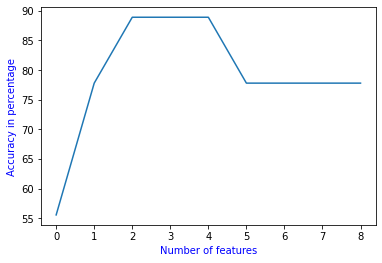

In [27]:
plt.plot(accuracy)
plt.xlabel("Number of features", color = 'b')
plt.ylabel("Accuracy in percentage", color = 'b')

## Without taking reference channel as C3

In [29]:
import random
relevant = []
for x in range(10):
    relevant.append(random.randint(0, 118))

signals2 = [];

nchannels = 10;
for i in relevant:
    signals2.append(signals[i]);
EEG = np.array(signals2);

In [30]:
# Dictionary to store the trials in, each class gets an entry
trials = {}

# The time window (in samples) to extract for each trial, here 0.5 -- 2.5 seconds
win = np.arange(int(0.5*sample_rate), int(2.5*sample_rate))

# Length of the time window
nsamples = len(win)

# Loop over the classes (right, foot)
for cl, code in zip(cl_lab, np.unique(event_codes)):
    print(cl, code)

    # Extract the onsets for the class
    cl_onsets = event_onsets[event_codes == code]
    
    # Allocate memory for the trials
    trials[cl] = np.zeros((nchannels, nsamples, len(cl_onsets)))
    
    # Extract each trial
    for i, onset in enumerate(cl_onsets):
        trials[cl][:,:,i] = EEG[:, win+onset]
  
 #Some information about the dimensionality of the data (channels x time x trials)
print('Shape of trials[cl1]:', trials[cl1].shape)
print(trials[cl1])
print('Shape of trials[cl2]:', trials[cl2].shape)

right 1
foot 2
Shape of trials[cl1]: (10, 2000, 18)
[[[  243.   419.   619. ...   105.   165.   -49.]
  [  238.   424.   653. ...    81.   150.   -49.]
  [  221.   434.   660. ...   108.   150.   -79.]
  ...
  [  218.   215.   457. ...   236.    48.   141.]
  [  240.   227.   420. ...   270.    44.   204.]
  [  245.   219.   432. ...   239.    22.   232.]]

 [[ -527.   -18.   -26. ...  -284.   -42.  -722.]
  [ -601.    62.   -17. ...  -297.   -13.  -666.]
  [ -647.   122.     2. ...  -322.    -9.  -620.]
  ...
  [ -626.  -425.    51. ...  -368.  -155.  -532.]
  [ -560.  -459.    25. ...  -329.  -137.  -559.]
  [ -556.  -498.   -15. ...  -304.   -92.  -579.]]

 [[  298.   411.   472. ...   219.   421.    98.]
  [  254.   440.   492. ...   208.   429.   125.]
  [  226.   463.   495. ...   211.   426.   124.]
  ...
  [  322.   127.   515. ...   443.   142.   288.]
  [  359.   118.   493. ...   484.   155.   303.]
  [  362.    91.   477. ...   495.   170.   321.]]

 ...

 [[ -693.  -611.  

In [31]:
# Apply the function
s = 3
trials_filt = []
for i in range(9):
    a = {cl1: bandpass(trials[cl1], s, s+5, sample_rate),
               cl2: bandpass(trials[cl2], s, s+5, sample_rate)}
    trials_filt.append(a);
    s+=4

In [32]:
# Percentage of trials to use for training (50-50 split here)
train_percentage = 0.7

# Calculate the number of trials for each class the above percentage boils down to

ntrain_r = int(trials_filt[0][cl1].shape[2] * train_percentage)
ntrain_f = int(trials_filt[0][cl2].shape[2] * train_percentage)
ntest_r = trials_filt[0][cl1].shape[2] - ntrain_r
ntest_f = trials_filt[0][cl2].shape[2] - ntrain_f

    # Splitting the frequency filtered signal into a train and test set
train = []; test = []; W = [];
for i in range(9):
    train.append({cl1: trials_filt[i][cl1][:,:,:ntrain_r],
             cl2: trials_filt[i][cl2][:,:,:ntrain_f]})

    test.append({cl1: trials_filt[i][cl1][:,:,ntrain_r:],
            cl2: trials_filt[i][cl2][:,:,ntrain_f:]})

    # Train the CSP on the training set only
    W.append(csp(train[i][cl1], train[i][cl2]))

    # Apply the CSP on both the training and test set
    train[i][cl1] = apply_mix(W[i], train[i][cl1])
    train[i][cl2] = apply_mix(W[i], train[i][cl2])
    test[i][cl1] = apply_mix(W[i], test[i][cl1])
    test[i][cl2] = apply_mix(W[i], test[i][cl2])

    # Select only the first and last components for classification
    #comp = np.array([0,1,2,3])
    train[i][cl1] = train[i][cl1][:,:,:]
    train[i][cl2] = train[i][cl2][:,:,:]
    test[i][cl1] = test[i][cl1][:,:,:]
    test[i][cl2] = test[i][cl2][:,:,:]

    # Calculate the log-var
    train[i][cl1] = logvar(train[i][cl1])
    train[i][cl2] = logvar(train[i][cl2])
    test[i][cl1] = logvar(test[i][cl1])
    test[i][cl2] = logvar(test[i][cl2])
    
#reshape to nchannelsx9featuresxtrials
train = {cl1 : f(train, cl1), cl2 : f(train, cl2)}
test = {cl1 : f(test, cl1), cl2 : f(test, cl2)}

In [33]:
x_train = [_]*10
dict = {}
for i in range(10):
    for j in range(9):
        dict[columns[j]] = train[cl1][i][j]
    x_train[i] = pd.DataFrame(dict)
for i in range(10):
    for j in range(9):
        dict[columns[j]] = train[cl2][i][j]
    x_train[i] = x_train[i].append(pd.DataFrame(dict), ignore_index=True)

x_test = [_]*10
for i in range(10):
    for j in range(9):
        dict[columns[j]] = test[cl1][i][j]
    x_test[i] = pd.DataFrame(dict)
for i in range(10):
    for j in range(9):
        dict[columns[j]] = test[cl2][i][j]
    x_test[i] = x_test[i].append(pd.DataFrame(dict), ignore_index=True)

In [34]:
y_train = np.full(train[cl1].shape[2],1, float)
y_train = np.append(y_train, np.full(train[cl2].shape[2],2, float))
y_test = np.full(test[cl1].shape[2],1, float)
y_test = np.append(y_test, np.full(test[cl2].shape[2],2, float))

In [35]:
selected_features = [_]*10
for i in range(10):
    selected_features[i] = mrmr_classif(X = x_train[i], y=y_train, K = 10) 

100%|█████████████████████████████████████████████| 9/9 [00:04<00:00,  2.21it/s]


In [36]:
for i in range(9):
    x_train[i].columns = selected_features[i]
    x_test[i].columns = selected_features[i]

In [37]:
l = ['ch' + str(i) + 'f' + str(j) for j in range(1, 10) for i in range(1, 11)];
len(l)
k = 0;
df_train = pd.DataFrame()
df_test = pd.DataFrame()
from sklearn import svm
y_pred = [_]*9
for i in range(9):
    for j in range(10):
        df_train[l[k]] = x_train[j].iloc[:,i:(i+1)]
        df_test[l[k]] = x_test[j].iloc[:,i:(i+1)]
        k+=1
    clf = svm.SVC(random_state = 42)
    clf.fit(df_train, y_train)
    y_pred[i] = clf.predict(df_test)

In [38]:
accuracy = [_]*9
for i in range(9):
    accuracy[i] = 100*(len(y_test) - (abs(y_pred[i] - y_test)).sum())/len(y_test)

In [39]:
np.max(accuracy)

77.77777777777777

Text(0, 0.5, 'Accuracy in percentage')

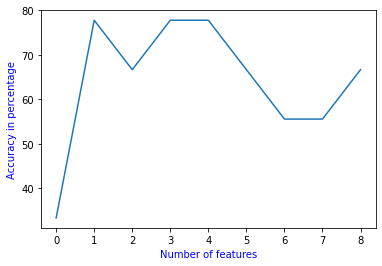

In [40]:
plt.plot(accuracy)
plt.xlabel("Number of features", color = 'b')
plt.ylabel("Accuracy in percentage", color = 'b')